In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from scipy.stats import norm

# Process Raw Input

In [2]:
url = 'https://raw.githubusercontent.com/mnuzen/156b-learning-support/master/data/us/covid/confirmed_cases.csv'
df = pd.read_csv(url, header=0)

In [3]:
print(df.head(5))

   countyFIPS            County Name State  stateFIPS  1/22/20  1/23/20  \
0           0  Statewide Unallocated    AL          1        0        0   
1        1001         Autauga County    AL          1        0        0   
2        1003         Baldwin County    AL          1        0        0   
3        1005         Barbour County    AL          1        0        0   
4        1007            Bibb County    AL          1        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  4/18/20  4/19/20  4/20/20  \
0        0        0        0        0  ...        0        0        0   
1        0        0        0        0  ...       25       27       28   
2        0        0        0        0  ...      109      114      117   
3        0        0        0        0  ...       18       20       22   
4        0        0        0        0  ...       26       28       32   

   4/21/20  4/22/20  4/23/20  4/24/20  4/25/20  4/26/20  4/27/20  
0        0        0        0        0      

In [4]:
cum_cases = df.iloc[:, 4:]
countyFIPS = df.iloc[:, 0].to_numpy()
daily_cases = cum_cases.diff(axis=1).to_numpy()
daily_cases[:,0] = cum_cases.iloc[:, 0]
cum_cases = cum_cases.to_numpy()

print(daily_cases)
print(daily_cases.shape)
print(cum_cases.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 2.]
 [0. 0. 0. ... 7. 7. 7.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3195, 97)
(3195, 97)


In [5]:
# divide the counties into groups to build different models
# 0-10 cumulative confirmed cases
group1 = []

# 11-100 cumulative confirmed cases
group2 = []

# 101-1000 cumulative confirmed cases
group3 = []

# more than 1000 cumulative confirmed cases
group4 = []
for i in range(len(cum_cases)):
    cases = cum_cases[i, -1]
    if cases <= 10:
        group1.append(i)
    elif cases <= 100:
        group2.append(i)
    elif cases <= 1000:
        group3.append(i)
    else:
        group4.append(i)
print(len(group1))
print(len(group2))
print(len(group3))
print(len(group4))

print(cum_cases[group4])
groups = [group1, group2, group3, group4]

1395
1137
527
136
[[   0    0    0 ... 3234 3359 3457]
 [   0    0    0 ... 1090 1136 1164]
 [   0    0    0 ... 1437 1468 1498]
 ...
 [   0    0    0 ... 2297 2311 2332]
 [   0    0    0 ...  976 1015 1034]
 [   0    0    0 ... 2525 2629 2674]]


# Building a Model

In [6]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=n_features)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

# Training a Model

In [7]:
def train_model(
    model,
    num_epochs,
    train_data,
    train_labels,
    test_data=None,
    test_labels=None,
):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(train_data)
#         print(y_pred.shape)
#         print(train_labels.shape)
        loss = loss_fn(y_pred.float(), train_labels)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(test_data)
                test_loss = loss_fn(y_test_pred.float(), test_labels)
            test_hist[t] = test_loss.item()
        
        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()
    if test_data is not None:
        print(f'Epoch {num_epochs} train loss: {loss.item()} test loss: {test_loss.item()}')
    else:
        print(f'Epoch {num_epochs} train loss: {loss.item()}')


    return model.eval(), train_hist, test_hist

# Create Sequences of Data

In [8]:
# create sequnces of k data points (X, y) 
# where X is an array of daily cases for "seq_length" consecutive days
# and y is the daily cases for "seq_length + 1"-th day
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Scaling and Prepare the Training and Test data

In [9]:
def scale_data(seq_length, train_data, test_data=None):
    # scale the data (values will be between 0 and 1) to increase the training speed and performance of the model
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)

    # create actual X (first k days),Y ((k+1)th day) for training
    X_train, y_train = create_sequences(train_data, seq_length)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()#.unsqueeze(1)
    
    if test_data is not None:
        test_data = scaler.transform(test_data)
        test_data_extended = np.concatenate((train_data[-seq_length:], test_data))
        print(test_data_extended.shape)
        X_test, y_test = create_sequences(test_data_extended, seq_length)
        X_test = torch.from_numpy(X_test).float()
        y_test = torch.from_numpy(y_test).float()#.unsqueeze(1)
        return scaler, X_train, y_train, X_test, y_test
    return scaler, X_train, y_train

# Choose the Number of Epochs, Hidden Nodes, Layers

(83, 1395)
(14, 1395)
(19, 1395)
torch.Size([78, 5, 1395])
torch.Size([78, 1395])
torch.Size([14, 5, 1395])
torch.Size([14, 1395])
layers = 2 hidden nodes = 700
Epoch 20 train loss: 1470.6090087890625 test loss: 2719.045166015625


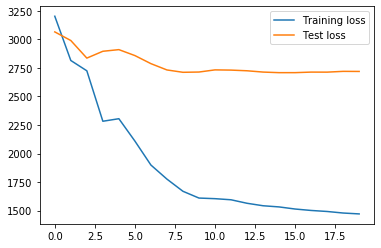

In [10]:
seq_length = 5
test_size = 14

train_data = daily_cases[group1, :-test_size]
test_data = daily_cases[group1, -test_size:]
# must transpose data########################
train_data = train_data.transpose()
test_data = test_data.transpose()
#############################################

print(train_data.shape)
print(test_data.shape)

my_scaler, X_train, y_train, X_test, y_test = scale_data(seq_length, train_data, test_data)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# for layers in range(2, 5):
#     for hidden in [128, 256, 512, 700]:
layers = 2
hidden = 700
print('layers = ' +str(layers) + ' hidden nodes = '+ str(hidden))
model = CoronaVirusPredictor(
  n_features=len(group1),
  n_hidden=hidden,
  seq_len=seq_length,
  n_layers=layers
)

model, train_hist, test_hist = train_model(
    model,
    20,
    X_train,
    y_train,
    X_test,
    y_test
)
plt.figure()
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()
plt.show()

As the number of layers increases, test performance worsen, so we choose the lowest number, 2.
As the number of hidden nodes increase, test performance gets better, so we choose 700 hidden nodes.
The lowest test error occurs at 2 layers and 700 hidden nodes (test loss = 5761).
We will use 20 epochs to train as test error ceases to drop after this.

# helper function: get date

In [11]:
#4-30, 5-31, 6-1
def get_date(days_since_41):
    days_since_41 += 1
    res = '2020-'
    if days_since_41 <= 9:
        res += '04-0' + str(days_since_41)
    elif days_since_41 <=30:
        res += '04-' + str(days_since_41)
    elif days_since_41 <=39:
        d = days_since_41 - 30 
        res += '05-0' + str(d)
    elif days_since_41 <= 61:
        d = days_since_41 - 30 
        res += '05-' + str(d)
    else:
        res = '2020-06-01'
    return res

# Predicting Daily Cases

In [12]:
FINAL_PRED = []
for g in range(len(groups)):
    group = groups[g]
    # building model using all current data
    my_scaler, X_train, y_train = scale_data(seq_length, daily_cases[group].transpose())
    # print(X_train.shape)
    # print(y_train.shape)

    model = CoronaVirusPredictor(
      n_features=len(group),
      n_hidden=700,
      seq_len=seq_length,
      n_layers=2
    )

    model_trained, train_hist, test_hist = train_model(
        model,
        20,
        X_train,
        y_train,
    )

    # since there are more than one day that we need to predict, we will use prediction as input value for later predictions
    # 1/22 - 6/1: 132 days inclusive
    # 4/1 - 6/1: 62 days inclusive
    # 1/22 - 4/1: 70 days excluding 4/1
    # the first sequence is 66-70

    with torch.no_grad():
        # when real X data is available
        real_X = X_train[66:]
        preds = model_trained(real_X).numpy()

        # when we need to use predicted X data
        # first sequence is the last 5 days of real data
        temp_y = y_train[-1:, :].unsqueeze(1)
        temp_X = X_train[-1:, 1:, :]
        test_seq = torch.cat((temp_X, temp_y), 1)

        for _ in range(len(daily_cases[0]) - 1, 132):
            pred = model_trained(test_seq)
            preds = np.concatenate((preds, pred.numpy()), axis=0)
            test_seq = torch.cat((test_seq[:, 1:, :], pred.unsqueeze(1)), 1)

    unscaled_preds = my_scaler.inverse_transform(preds)
    cum_preds = np.zeros((62, len(unscaled_preds[0])))
    cum_preds[0] = np.add(cum_cases[group, 70], unscaled_preds[0])
    for i in range(len(unscaled_preds) - 1):
        cum_preds[i+1] = np.add(cum_preds[i], unscaled_preds[i+1])
    
    # assume normal distribution
    std = 10**(g/2)
    for date in range(len(cum_preds)):
        for county in range(len(cum_preds[0])):
            heading = get_date(date) + '-' + str(countyFIPS[group[county]])
            mean = cum_preds[date, county]
            quantiles = np.linspace(norm.ppf(0.1, mean, std), norm.ppf(0.9, mean, std), 9).tolist()
            quantiles.insert(0, heading)
            FINAL_PRED.append(quantiles)
    print(np.array(FINAL_PRED).shape)  


Epoch 20 train loss: 2158.6552734375
(86490, 10)
Epoch 20 train loss: 2620.36767578125
(156984, 10)
Epoch 20 train loss: 1119.0284423828125
(189658, 10)
Epoch 20 train loss: 293.8252868652344
(198090, 10)


In [358]:
FINAL_PRED = np.array(FINAL_PRED)
df = pd.DataFrame(data={"id": FINAL_PRED[:, 0], 
                        "10": FINAL_PRED[:, 1], 
                        "20": FINAL_PRED[:, 2], 
                        "30": FINAL_PRED[:, 3], 
                        "40": FINAL_PRED[:, 4], 
                        "50": FINAL_PRED[:, 5], 
                        "60": FINAL_PRED[:, 6], 
                        "70": FINAL_PRED[:, 7], 
                        "80": FINAL_PRED[:, 8], 
                        "90": FINAL_PRED[:, 9]})
df.to_csv("./submission_lstm.csv", sep=',',index=False)

In [ ]:
# plt.plot(
#   range(len(train_data)),
#   train_data,
#   label='Historical Daily Cases'
# )

# plt.plot(
#   range(len(train_data), len(train_data) + len(true_cases)),
#   test_data,
#   label='Real Daily Cases'
# )

# plt.plot(
#   range(len(train_data), len(train_data) + len(true_cases)),
#   predicted_cases,
#   label='Predicted Daily Cases'
# )

# plt.legend()
# plt.show()